In [2]:
import librosa
import numpy as np

def extract_mfcc(file_path, n_mfcc=40, max_pad_len=44):
    # Load the audio file
    y, sr = librosa.load(file_path, duration=3)  # Load 3 seconds of audio
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Pad or truncate to ensure consistent size
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    
    return mfcc

# Example
file_path = r"D:\model\down\2.wav"
mfcc_features = extract_mfcc(file_path)
print(mfcc_features.shape)  # Should output (40, 44)


(40, 44)


In [3]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming you have audio data organized by class folders
data_dir = r"D:\model"
labels = []
features = []

# Load each file, extract MFCC, and collect its label
for label, class_dir in enumerate(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_dir)
    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        mfcc = extract_mfcc(file_path)
        features.append(mfcc)
        labels.append(label)

# Convert to numpy arrays
features = np.array(features)
labels = to_categorical(np.array(labels))

# Reshape features for CNN input
features = features[..., np.newaxis]  # Add channel dimension (40, 44, 1)



In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_audio_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage
input_shape = (40, 44, 1)  # 40 MFCC coefficients, 44 time steps
num_classes = 6  # Adjust this to match your classes
model = create_audio_model(input_shape, num_classes)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 44, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 11, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 128)        0

In [7]:
# Ensure TensorFlow runs on GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth to avoid crashes
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Running on GPU:", gpus[0])
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


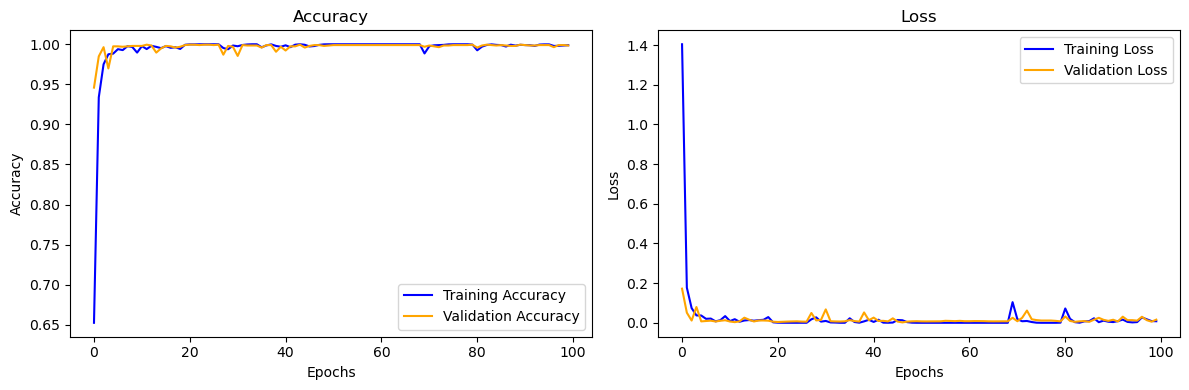

241/241 [==============================] - 2s 9ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.0158 - val_accuracy: 0.9984


In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
import datetime
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
import datetime
class LivePlotCallback(Callback):
    def on_train_begin(self, logs=None):
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
        plt.ion()  # Turn on interactive mode

    def on_epoch_end(self, epoch, logs=None):
        # Update history
        self.history['accuracy'].append(logs['accuracy'])
        self.history['val_accuracy'].append(logs['val_accuracy'])
        self.history['loss'].append(logs['loss'])
        self.history['val_loss'].append(logs['val_loss'])
        
        # Clear output and redraw the updated plot
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history['accuracy'], label='Training Accuracy', color='blue')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy', color='orange')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history['loss'], label='Training Loss', color='blue')
        plt.plot(self.history['val_loss'], label='Validation Loss', color='orange')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Add this callback to your model training
live_plot = LivePlotCallback()

# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[live_plot, tensorboard_callback]  # TensorBoard still works alongside!
)



In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.6f}%")

path = r"D:\model\right\27.wav"
# Predicting a new file
new_file = extract_mfcc(path)
new_file = np.expand_dims(new_file, axis=(0, -1))  # Reshape for model input
prediction = model.predict(new_file)
print("Predicted class:", np.argmax(prediction))


61/61 [==============================] - 0s 6ms/step - loss: 0.0158 - accuracy: 0.9984
Test accuracy: 99.843913%
1/1 [==============================] - 0s 171ms/step
Predicted class: 4


In [12]:
model.save('audio_classification_model.h5')


In [13]:
import tensorflow as tf
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('audio_classification_model.h5')

# Define a representative dataset function for proper quantization
def representative_dataset():
    for i in range(100):  # Use samples from your training data
        yield [X_train[i:i+1].astype(np.float32)]

# Convert model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set optimization to default (enables quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide representative dataset for int8 quantization
converter.representative_dataset = representative_dataset

# Force inputs/outputs to int8 for TensorFlow Lite Micro compatibility
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert and save the model
tflite_model = converter.convert()

with open('audio_classification_model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Model converted and quantized!")


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpgm1i8nei\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpgm1i8nei\assets
c:\Users\HP\miniconda3\envs\py310\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


✅ Model converted and quantized!


In [ ]:
python -m xxd -i audio_classification_model_int8.tflite > audio_model.h
